# Logistic Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

### The Model

In [51]:
def logistic_regression(X, y, max_iter = 1000, learning_rate = 0.01, tolerance = 0.01, learning_rate_decay = False,
                       l2_penalty = 0.0):
    '''Runs Gradient descent on the data for bianry classification and returns learned parameters by the model.
    Assumes y in {0,1} 
    '''
    
    m = X.shape[0]                                      # Training Examples
    n = X.shape[1]                                      # No. of features
    X = np.hstack((np.ones((m,1)), X))                  # Adding a column of ones for 0th feature i.e. Intercept
    w = np.zeros((n+1, 1))                              # Initialization of weights
    
    costs = []
    grad_magnitudes = []
    
    for t in range(max_iter):
        
        # Prediction
        y_cap = sigmoid(np.matmul(X, w))
        # Cost
        cost = (-1.0 / m) * np.sum(y * np.log(y_cap) + (1 - y) * np.log(1 - y_cap))
        # Regularization term
        cost += (l2_penalty / m) * np.sum(w ** 2)
        # Gradients
        dw = (1.0 / m) * np.matmul(X.T, y_cap - y)
        # Weight Penalization except intercept
        dw[1:, :] += (2.0 * l2_penalty / m) * w[1:, :]
        # Update Parameters
        w = w - learning_rate * dw
        
        if learning_rate_decay and (t+1) % 100 == 0:
            learning_rate = learning_rate / np.sqrt(t)    # Learning rate decay over every 100th iteration
            
        grad_magnitude = np.linalg.norm(dw)
        if grad_magnitude < tolerance:                   # If converged
            break
            
        costs.append(cost)
        grad_magnitudes.append(grad_magnitude)
    
    return w, costs, grad_magnitudes


def sigmoid(x):
    
    return 1.0 / (1 + np.exp(-x))


def predict(X, w):
    
    if X.shape[1] < w.shape[0]:
        X = np.hstack((np.ones((X.shape[0],1)), X))
        
    y = sigmoid(np.matmul(X, w))
    
    return y > 0.5


def accuracy(X, y, w):
    
    y_cap = predict(X, w)
    
    return 100 * np.sum(y == y_cap) / X.shape[0]

### Data ---> Cat vs non Cat Classification

Predict whether there is cat in the image based on pixel intensities of the image.

In [320]:
data1 = h5py.File('data/train_catvnoncat.h5', 'r')
data2 = h5py.File('data/test_catvnoncat.h5', 'r')
X = np.vstack((np.array(data1['train_set_x']), np.array(data2['test_set_x'])))
y = np.vstack((np.array(data1['train_set_y']).reshape(-1,1), np.array(data2['test_set_y']).reshape(-1,1)))
print(X.shape, y.shape)

(259, 64, 64, 3) (259, 1)


We have 259 RGB images of 64 by 64 pixels and their corresponding labels

#### Showing some random images and their labels 0 for non cat and 1 for cat

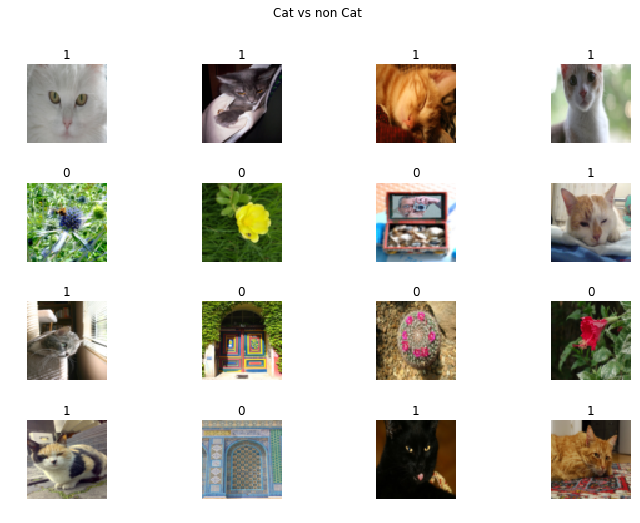

In [74]:
plt.figure(figsize=(12,8))
plt.suptitle("Cat vs non Cat")
for i in range(1,17):
    ind=np.random.randint(0, 259)
    plt.subplot(4,4,i)
    plt.axis("off")
    plt.imshow(X[ind, :, :, :])
    plt.title(str(y[ind, 0]))
    plt.subplots_adjust(hspace=0.5)

#### Reshaping, Normalizing and Train Test split

Since shape of the data is (m, 64, 64, 3) but we want (m, 64 * 64 * 3) i.e. (m, 12288) Therefore reshaping the data to desired shape.<br>
Normalizing the image data is quite straightforward just dividing by 255 (max intensity value).<br>
80:20 split of the data for estimating generalization error of the model.

In [321]:
X = X.reshape(-1, X.shape[1] * X.shape[2] * X.shape[3])
X = X / 255

train_size = int(0.8*X.shape[0])
random_indices = np.random.permutation(X.shape[0])
X_train = X[random_indices[:train_size], :]
X_test = X[random_indices[train_size:], :]
y_train = y[random_indices[:train_size], :]
y_test = y[random_indices[train_size:], :]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(207, 12288) (52, 12288) (207, 1) (52, 1)


### Training the model on training data

In [322]:
w, costs, grads = logistic_regression(X_train, y_train, max_iter=2000)

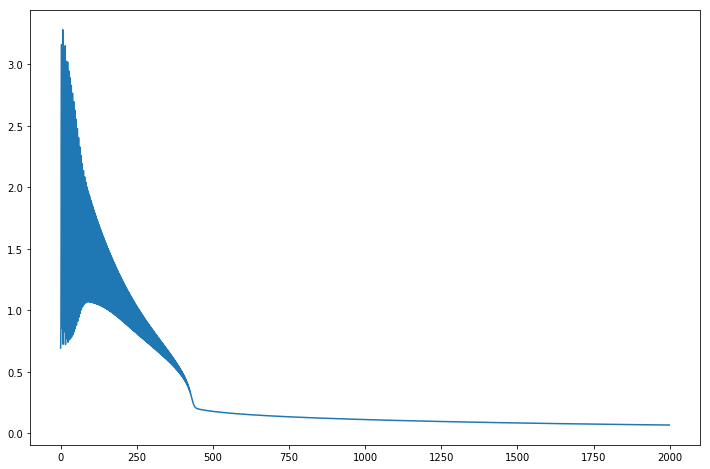

In [323]:
plt.figure(figsize=(12,8))
plt.plot(costs)

We can see the cost going down with the number of iterations.

#### Train Accuracy

In [324]:
print('{:.2f}%'.format(accuracy(X_train, y_train, w)))

100.00%


#### Test Accuracy

In [325]:
print('{:.2f}%'.format(accuracy(X_test, y_test, w)))

67.31%


We can see that the model has high variance. It has overfitted the training data because the test accuracy is far less than the train accuracy.

### L2 Regularized Logistic Regression

#### k-fold cross validation

In [296]:
def k_fold_cross_validation(X, y, l2_penalty_list, k=10):
    
    m = X.shape[0]                            # No. of examples
    n = X.shape[1]                            # No. of features
    
    validation_accuracies = []
    
    for l2_penalty in l2_penalty_list:
        
        validation_accuracy = 0.0
        
        for i in range(k):
            
            start = (m * i) // k
            end = (m * (i + 1)) // k-1
            
            X_valid = X[start:end+1, :]
            y_valid = y[start:end+1, :]
            
            X_train = np.append(X[:start, :], X[end+1:, :], axis=0)
            y_train = np.append(y[:start, :], y[end+1:, :], axis=0)
            
            w = logistic_regression(X_train, y_train, l2_penalty=l2_penalty, max_iter=2000)[0]
            
            validation_accuracy += accuracy(X_valid, y_valid, w)
            
        validation_accuracy /= k
        validation_accuracies.append(validation_accuracy)
    
    return validation_accuracies        

#### Running k-fold cross validation on training data to find best value of L2_penalty

In [314]:
l2_penalty_list = np.logspace(-2, 2, num=10)
validation_accuracies = k_fold_cross_validation(X_train, y_train, l2_penalty_list)

#### Training the model with best value of L2_penalty determined by k-fold cross validation

In [315]:
w = logistic_regression(X_train, y_train, l2_penalty=l2_penalty_list[np.argmax(validation_accuracies)])[0]

#### Train Accuracy for L2 Regularized Logistic Regression

In [318]:
print('{:.2f}%'.format(accuracy(X_train, y_train, w)))

99.03%


#### Test Accuracy for L2 Regularized Logistic Regression

In [319]:
print('{:.2f}%'.format(accuracy(X_test, y_test, w)))

71.15%


We can see an increase in test set performance with a little compromise on training set performance